In [46]:
from dataclasses import dataclass
from itertools import product
from pathlib import Path
from typing import Callable, NamedTuple, Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage as sk
import skimage.io as skio
from numpy import ndarray
from PIL import Image

# Input images

In [162]:
data_dir, extra_dir, out_dir = Path("data"), Path("extra"), Path("output")
adjust_dir = Path("output/adjust")
out_dir.mkdir(parents=True, exist_ok=True)

low_res_imgs = list(data_dir.glob("*.jpg"))
high_res_imgs = list(data_dir.glob("*.tif"))
extra_imgs = list(extra_dir.glob("*"))

print(f"number of images = {len(low_res_imgs)}")
print(f"number of images = {len(high_res_imgs)}")
print(f"number of images = {len(extra_imgs)}")

number of images = 3
number of images = 11
number of images = 4


# Aligning Channels

## Helper Functions

In [48]:
class Displacement(NamedTuple):
    """Start of each color as a row."""

    r: int
    g: int
    b: int = 0


class Offset(NamedTuple):
    row: int = 0
    col: int = 0

In [49]:
def channel_height(img: ndarray):
    return img.shape[0] // 3


def channel_width(img: ndarray):
    return img.shape[1]

def channels(img, disp: Displacement, h:int, w:int) -> Tuple[ndarray, ndarray, ndarray]:
    # create channel matrices
    # print(B_start, G_start, R_start, h, w)
    r, g, b = disp.r, disp.g, disp.b
    B_mat = img[b : b + h, :w]
    G_mat = img[g : g + h, :w]
    R_mat = img[r : r + h, :w]
    return R_mat, G_mat, B_mat

In [87]:
# Returns a sub_matrix extracted from img
def sub_image(
    img: ndarray,
    start: int,
    offset: Offset = Offset(0,0),
    pad_val: float = np.inf,
) -> ndarray:
    # initialize entries of result to 'inf'
    h, w = channel_height(img), channel_width(img)
    result = np.full((h - 2 * offset.row, w - 2 * offset.col), pad_val)

    # extract sub_matrix from img
    a = img[
        start + offset.row : start + h - offset.row,
        0 + offset.col : 0 + w - offset.col,
    ]
    result[: a.shape[0], : a.shape[1]] = a
    return result


# Returns row displacements of G and R channels using the chosen algorithm
def align_with(img, algorithm, *args):
    # algorithm can be align_basic, align_ssd, align_ncc
    # refer to each algorithm for corresponding *args
    return algorithm(img, *args)

## Alignment Algorithms

### Basic

In [51]:
# Returns alignment index by simply dividing the image in 3
def align_basic(img: ndarray) -> Displacement:
    G_start = channel_height(img)  # floor division to get integer indices
    R_start = channel_height(img) * 2
    return Displacement(g=G_start, r=R_start)

### SSD

In [83]:
# Returns the ssd between matrix a and matrix b
def ssd(a: ndarray, b: ndarray) -> float:
    return np.sum((a - b) ** 2)


# Returns row displacements that give best result
def align_ssd(
    img: ndarray, displacement: int = 20, offset=Offset(row=20, col=20)
) -> Displacement:
    h, _ = channel_height(img), channel_width(img)

    B_start = 0
    G_start = h
    R_start = 2 * h

    b = sub_image(img, B_start, offset)
    # find displacement for G channel
    score = {}
    for d in range(-displacement, displacement):
        g = sub_image(img, G_start + d, offset)
        score[d] = ssd(b, g)
    G_start += min(score)
    # find displacement for R channel
    score.clear()
    for d in range(1, displacement):
        r = sub_image(img, R_start + d, offset)
        score[d] = ssd(b, r)
    R_start += min(score)
    return Displacement(g=G_start, r=R_start)

### NCC

In [93]:
# Returns the ncc between matrix a and matrix b
def ncc(a: ndarray, b: ndarray) -> float:
    assert(a.shape == b.shape)
    s = np.array([a[r] @ b[r] for r in range(a.shape[0])])
    return np.sum(s)


# Returns row displacements that give best result
def align_ncc(
    img: ndarray, displacement: int = 20, offset=Offset(row=20, col=20)
) -> Displacement:
    h, _ = channel_height(img), channel_width(img)

    B_start = 0
    G_start = h
    R_start = 2 * h

    b = sub_image(img, B_start, offset)
    # find displacement for G channel
    score = {}
    for d in range(-displacement, displacement):
        g = sub_image(img, G_start + d, offset, pad_val=0.)
        score[d] = ssd(b, g)
    G_start += min(score)
    # find displacement for R channel
    score.clear()
    for d in range(1, displacement):
        r = sub_image(img, R_start + d, offset, pad_val=0.)
        score[d] = ncc(b, r)
    R_start += min(score)
    return Displacement(g=G_start, r=R_start)

## Image Pyramid

In [54]:
def pyramid(
    img: ndarray, align_metric: Callable[[ndarray, ndarray], ndarray], *args
) -> Displacement:
    if img.size < 1500 * 500:
        return align_metric(img, *args)
    im_resize = cv2.resize(img, (img.shape[0] // 2, img.shape[1] // 2))
    new_pyr = pyramid(im_resize, align_metric, *args)
    g_est, r_est = new_pyr.g,new_pyr.r
    G_start = int(np.round(g_est / im_resize.shape[0] * img.shape[0]))
    R_start = int(np.round(r_est / im_resize.shape[0] * img.shape[0]))
    return Displacement(g=G_start, r=R_start)

# Test and Display Results

In [151]:
def save_n_display(images, out_dir:Path, algorithm, *args, adjust=False):
    for n in range(len(images)):
        # read input file
        im = cv2.imread(str(images[n]), cv2.IMREAD_GRAYSCALE)
        #plt.figure()
        #plt.imshow(im, cmap=plt.get_cmap("gray"))

        # set channel size
        h, w = channel_height(im), channel_width(im)

        # compute displacements
        d = Displacement(0, 0, 0)
        d = pyramid(im, algorithm)
        print(f'"The displacements are: {d}"')
        
        # combine channels and display result
        R_mat, G_mat, B_mat = channels(im, d, h, w)
        #print(R_mat.shape, G_mat.shape, B_mat.shape)
        result = np.dstack([R_mat, G_mat, B_mat])
        plt.figure()
        plt.imshow(result)

        # save the images
        fname = out_dir / images[n].stem
        Image.fromarray(result).save(fname, "PNG")
    return result

## Testing low resolution images

"The displacements are: Displacement(r=683, g=321, b=0)"
"The displacements are: Displacement(r=683, g=321, b=0)"
"The displacements are: Displacement(r=683, g=321, b=0)"


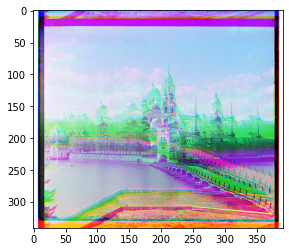

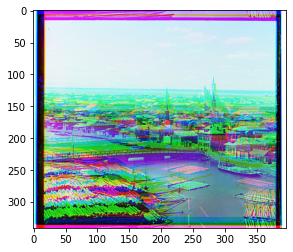

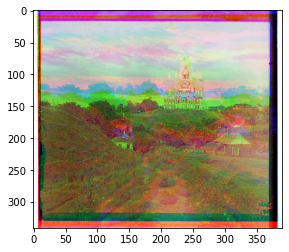

In [152]:
if __name__ == "__main__":
    save_n_display(low_res_imgs, out_dir, align_ssd)

"The displacements are: Displacement(r=683, g=321, b=0)"
"The displacements are: Displacement(r=683, g=321, b=0)"
"The displacements are: Displacement(r=683, g=321, b=0)"


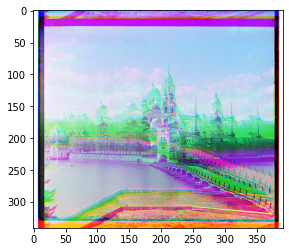

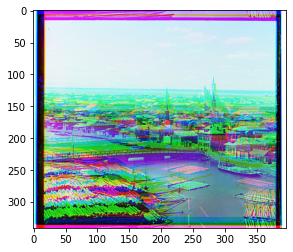

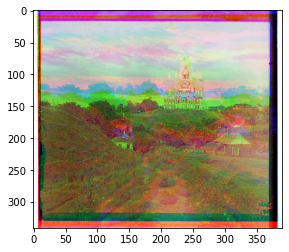

In [95]:
if __name__ == "__main__":
    save_n_display(low_res_imgs, out_dir, align_ncc)

## Testing high resolution images

"The displacements are: Displacement(r=6389, g=3197, b=0)"
"The displacements are: Displacement(r=6418, g=3209, b=0)"
"The displacements are: Displacement(r=6393, g=3194, b=0)"


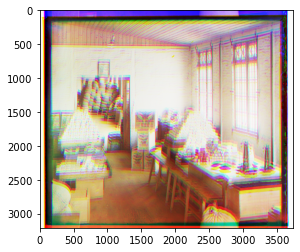

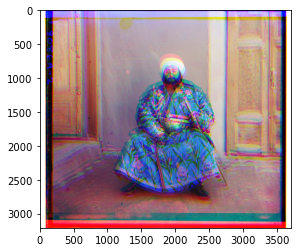

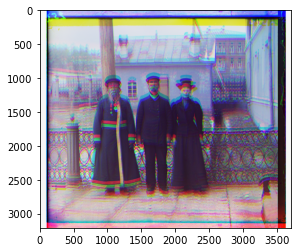

In [97]:
if __name__ == "__main__":
    save_n_display(high_res_imgs[:3], out_dir, align_basic)

# Adjustments

## Normalize Exposures

In [136]:
# takes in a matrix with values within [1,0],
# and transforms it so that the minimum value becomes 0, maximum value becomes 1
def fix_exposure(mat: ndarray, show=False) -> None:
    unit_len = np.max(mat) - np.min(mat)
    mat = (mat - np.amin(mat)) / unit_len
    if show:
        plt.imshow(mat)

## Crop Borders

In [137]:
def find_border(mat, axis):
    # zero pad mat at rightmost and bottom
    mat_padded = np.pad(mat, ((0, 1), (0, 1), "constant", 0))
    
    val_r, val_c = [], []
    # find row border
    for i in range[mat.shape[0]]:
        val_r[i, i + 1] = mat_padded[i] @ mat_padded[i + 1]
    r_cutoff = np.unravel_index(np.argmin(val))[1]
    # find col border
    for i in range[mat.shape[1]]:
        val_c[i, i + 1] = mat_padded[:, [i]] @ mat_padded[:, [i + 1]]
    c_cutoff = np.unravel_index(np.argmin(val))[1]
    return [r_cutoff, c_cutoff]

def crop_borders(mat, show=False):
    find_border(mat)
    if show:
        plt.imshow(balanced_im)

## Auto White Balance (AWB)

In [144]:
# Automatic (AWB)
# • Grey World: force average color of scene to grey
# • White World: force brightest object to white

def awb_grey(im, show=False):
    # Compute the mean color over the entire image
    avg_color = np.mean(im)

    # Scale the averge color to be grey (0.5)
    scaling = 0.5 / avg_color

    # Apply the scaling to the entire image
    balanced_im = im * scaling
    if show:
        plt.imshow(balanced_im)
    im = balanced_im

def awb_white(im, show=False):
    # Compute the brightest color over the entire image
    brightest_color = np.amax(im)

    # Scale the brightest color to be white (1.0)
    scaling = 1.0 / brightest_color

    # Apply the scaling to the entire image
    balanced_im = im * scaling
    if show:
        plt.imshow(balanced_im)
    im = balanced_im

## Apply Adjustments

"The displacements are: Displacement(r=683, g=321, b=0)"


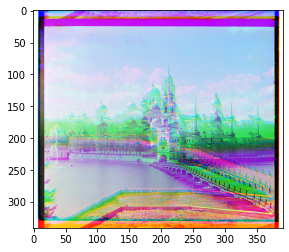

In [153]:
im_aligned = save_n_display(low_res_imgs[:1], out_dir, align_ssd)
awb_grey(im_aligned, show=True)
#awb_white(im_aligned, show=True)
fix_exposure(im_aligned, show=True)
#crop_borders(im_aligned, show=True)

"The displacements are: Displacement(r=682, g=341, b=0)"


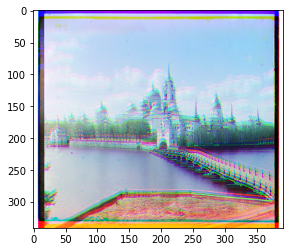

In [150]:
im_aligned = save_n_display(low_res_imgs[:1], out_dir, align_basic)
#awb_grey(im_aligned, show=True)
awb_white(im_aligned, show=True)
fix_exposure(im_aligned, show=True)
#crop_borders(im_aligned, show=True)